In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
COLORS = ["#0173B2", "#DE8F05", "#029E73", "#D55E00", "#CC78BC",
        "#CA9161", "#FBAFE4", "#949494", "#ECE133", "#56B4E9"]
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color = COLORS) 

import torch
import torch.nn.functional as F

from torchvision import datasets, transforms
from skimage.metrics import structural_similarity
from model import LSHN

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

def generate_mask(batch):
    mask = torch.zeros_like(batch, device=batch.device)
    mask[:,:mask.shape[-1]//2] = 1.
    return mask

def pattern2img(x):
    if int(x.shape[-1] ** 0.5) ** 2 == x.shape[-1]:
        img_size = int(x.shape[-1] ** 0.5)
    else:
        img_size = int((x.shape[-1] // 3) ** 0.5)
    if len(x.shape) == 1:
        return (x.reshape(img_size, img_size, -1).cpu().numpy() + 1) / 2.
    elif len(x.shape) == 2:
        return (x.reshape(x.shape[0], img_size, img_size, -1).cpu().numpy() + 1) / 2.

def calculate_ssim(img1, img2):
    img1 = (img1 * 255).astype(np.uint8)
    img2 = (img2 * 255).astype(np.uint8)
    if (img1.shape) == 3:
        img1 = img1[None]
        img2 = img2[None]
    ssim_list = []
    for idx in range(len(img1)):
        ssim_total = 0.
        for i in range(img1.shape[-1]):
            score, _ = structural_similarity(img1[idx, :, :, i], img2[idx, :, :, i], full=True)
            ssim_total += score
        ssim_list.append(ssim_total / img1.shape[-1])
    return ssim_list

def Fraction_correctly_retrieved(recon_image, target, threshold=50):
    return 1.0 * ((((recon_image - target) / 2.) ** 2).sum(-1) <= threshold)


### Prepare dataset

In [2]:
# dataset_name = 'MNIST' # 1*28*28
dataset_name = 'CIFAR10' # 3*32*32

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) if dataset_name == 'MNIST' else transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

if dataset_name == 'MNIST':
    dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
elif dataset_name == 'CIFAR10':
    dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

whole_patterns_raw = []
labels_raw = []

for i in range(5000):
    item = dataset.__getitem__(i)
    whole_patterns_raw.append(item[0].permute(1,2,0).flatten()[None])
    labels_raw.append(item[1])
whole_patterns_raw = torch.cat(whole_patterns_raw, 0).flatten(1, -1).cuda()
labels_raw = np.array(labels_raw)


Files already downloaded and verified


### Calculate metrics for half-masked images retrieval (capacity)

In [3]:
total_step = 20000
eval_results = {}

for to_hebb_hopfield in [False]: #[False, True]:
    for emb_size in [128]: #[128, 256, 512, 1024]:
        for num_pattern in [100]: #[2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 3000, 4000, 5000]:
            for random_idx in [0]: #range(4):
                ckpt_path = f'./outputs/attractor-{dataset_name}-ckpt/N={emb_size}-npat={num_pattern}-{total_step}step-{random_idx}.pt'
                if to_hebb_hopfield:
                    npz_path = ckpt_path.replace('.pt', '-halfmask-hebb.npz')
                else:
                    npz_path = ckpt_path.replace('.pt', '-halfmask.npz')
                if not os.path.exists(npz_path):
                    print(f' ---------------- num_pattern : {num_pattern} ---------------- ')
                    whole_patterns = whole_patterns_raw[:num_pattern].clone()
                    model = LSHN(['latent'], emb_size, image_size=whole_patterns_raw.shape[-1]).cuda()
                    model.load_state_dict(torch.load(ckpt_path))
                    model.eval()
                    model.set_dt(0.1)
                    with torch.no_grad():
                        batch = whole_patterns.clone()
                        mask = generate_mask(batch)
                        noisy_batch = batch * mask

                        target_attractors = model.image_to_attractor(batch)
                        noisy_attractors  = model.image_to_attractor(noisy_batch)

                        if to_hebb_hopfield:
                            model.set_whole_RNN_weight(target_attractors.transpose(1, 0) @ target_attractors / target_attractors.shape[0] / target_attractors.shape[1])

                        recon_attractors = noisy_attractors.clone()
                        recon_image_noisy_list = []
                        for i in range(1000):
                            if i < 10:
                                recon_image_noisy_list.append(model.attractor_to_image(recon_attractors).clamp(-1, 1).cpu())
                            recon_attractors = model.attractor_iteration(recon_attractors, ento_input=noisy_attractors)
                        recon_attractors = torch.sign(recon_attractors)

                        recon_image_masked_target = model.attractor_to_image(noisy_attractors).clamp(-1, 1)
                        recon_image_target = model.attractor_to_image(target_attractors).clamp(-1, 1)
                        recon_image_noisy = model.attractor_to_image(recon_attractors).clamp(-1, 1)

                        print('recon from recalled attractor' + ('(hebb)' if to_hebb_hopfield else ''))
                        print(f'acc : {Fraction_correctly_retrieved(recon_image_noisy, batch).mean()}; MAE : {F.l1_loss(recon_image_noisy, batch)}; MSE : {F.mse_loss(recon_image_noisy, batch)}')

                        np.savez(
                            npz_path,
                            img = batch.cpu().numpy(),
                            masked_img = noisy_batch.cpu().numpy(),
                            recon_img = recon_image_noisy.cpu().numpy(),

                            recon_img_acc_thre50 = Fraction_correctly_retrieved(recon_image_noisy, batch, threshold=50).cpu().numpy(),
                            recon_img_MAE = (recon_image_noisy - batch).abs().mean(-1).cpu().numpy(),
                            recon_img_MSE = ((recon_image_noisy - batch) ** 2).mean(-1).cpu().numpy(),
                            recon_img_ssim = calculate_ssim(pattern2img(recon_image_noisy), pattern2img(batch)),

                            fake_recon_img_acc_thre50 = Fraction_correctly_retrieved(recon_image_noisy, recon_image_target, threshold=50).cpu().numpy(),
                            fake_recon_img_MAE = (recon_image_noisy - recon_image_target).abs().mean(-1).cpu().numpy(),
                            fake_recon_img_MSE = ((recon_image_noisy - recon_image_target) ** 2).mean(-1).cpu().numpy(),
                            fake_recon_img_ssim = calculate_ssim(pattern2img(recon_image_noisy), pattern2img(recon_image_target)),

                            target_attractors = target_attractors.cpu().numpy(),
                            recon_attractor = recon_attractors.cpu().numpy(),
                            recon_attractor_acc = (1. - (recon_attractors - torch.sign(target_attractors)).abs() / 2.).mean(-1).cpu().numpy(),
                        )
                eval_results[f'{emb_size}-{num_pattern}-{random_idx}-{to_hebb_hopfield}'] = np.load(npz_path)


 ---------------- num_pattern : 100 ---------------- 
recon from recalled attractor
acc : 0.9799999594688416; MAE : 0.018896514549851418; MSE : 0.004063637927174568


### Calculate metrics for gaussian noisy images retrieval (capacity)

In [4]:
total_step = 20000
eval_results = {}

sigma_list = [0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 1., 1.5]
for to_hebb_hopfield in [False]: #[False, True]:
    for emb_size in [128]: #[128, 256, 512, 1024]:
        for num_pattern in [100]: #[2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 3000, 4000, 5000]:
            for random_idx in [0]: #range(4):
                ckpt_path = f'./outputs/attractor-{dataset_name}-ckpt/N={emb_size}-npat={num_pattern}-{total_step}step-{random_idx}.pt'

                print(f' ---------------- num_pattern : {num_pattern} ---------------- ')
                whole_patterns = whole_patterns_raw[:num_pattern].clone()
                model = LSHN(['latent'], emb_size, image_size=whole_patterns_raw.shape[-1]).cuda()
                model.load_state_dict(torch.load(ckpt_path))
                model.eval()
                model.set_dt(0.1)
                with torch.no_grad():
                    for sigma in sigma_list:
                        if to_hebb_hopfield:
                            npz_path = ckpt_path.replace('.pt', f'-Normal{sigma}-hebb.npz')
                        else:
                            npz_path = ckpt_path.replace('.pt', f'-Normal{sigma}.npz')
                        if not os.path.exists(npz_path):
                            print(f'---- sigma = {sigma} ----')
                            batch = whole_patterns.clone()

                            perturb = torch.normal(0, sigma, size=batch.shape, device=batch.device)
                            noisy_batch = torch.clamp(torch.abs((batch + 1) / 2. + perturb), 0, 1) * 2. - 1

                            target_attractors = model.image_to_attractor(batch)
                            noisy_attractors  = model.image_to_attractor(noisy_batch)

                            if to_hebb_hopfield:
                                model.set_whole_RNN_weight(target_attractors.transpose(1, 0) @ target_attractors / target_attractors.shape[0] / target_attractors.shape[1])

                            recon_attractors = noisy_attractors.clone()
                            recon_image_noisy_list = []
                            for i in range(1000):
                                if i < 10:
                                    recon_image_noisy_list.append(model.attractor_to_image(recon_attractors).clamp(-1, 1).cpu())
                                recon_attractors = model.attractor_iteration(recon_attractors, ento_input=noisy_attractors)
                            recon_attractors = torch.sign(recon_attractors)

                            recon_image_masked_target = model.attractor_to_image(noisy_attractors).clamp(-1, 1)
                            recon_image_target = model.attractor_to_image(target_attractors).clamp(-1, 1)
                            recon_image_noisy = model.attractor_to_image(recon_attractors).clamp(-1, 1)

                            print('recon from recalled attractor')
                            print(f'acc : {Fraction_correctly_retrieved(recon_image_noisy, batch).mean()}; MAE : {F.l1_loss(recon_image_noisy, batch)}; MSE : {F.mse_loss(recon_image_noisy, batch)}')

                            np.savez(
                                npz_path,
                                img = batch.cpu().numpy(),
                                masked_img = noisy_batch.cpu().numpy(),
                                recon_img = recon_image_noisy.cpu().numpy(),

                                recon_img_acc_thre50 = Fraction_correctly_retrieved(recon_image_noisy, batch, threshold=50).cpu().numpy(),
                                recon_img_MSE = ((recon_image_noisy - batch) ** 2).mean(-1).cpu().numpy(),
                                recon_img_ssim = calculate_ssim(pattern2img(recon_image_noisy), pattern2img(batch)),

                                fake_recon_img_acc_thre50 = Fraction_correctly_retrieved(recon_image_noisy, recon_image_target, threshold=50).cpu().numpy(),
                                fake_recon_img_MAE = (recon_image_noisy - recon_image_target).abs().mean(-1).cpu().numpy(),
                                fake_recon_img_MSE = ((recon_image_noisy - recon_image_target) ** 2).mean(-1).cpu().numpy(),
                                fake_recon_img_ssim = calculate_ssim(pattern2img(recon_image_noisy), pattern2img(recon_image_target)),

                                target_attractors = target_attractors.cpu().numpy(),
                                recon_attractor = recon_attractors.cpu().numpy(),
                                recon_attractor_acc = (1. - (recon_attractors - torch.sign(target_attractors)).abs() / 2.).mean(-1).cpu().numpy(),
                            )
                        eval_results[f'{emb_size}-{num_pattern}-{random_idx}-{to_hebb_hopfield}-{sigma}'] = np.load(npz_path)


 ---------------- num_pattern : 100 ---------------- 
---- sigma = 0.05 ----
recon from recalled attractor
acc : 0.9199999570846558; MAE : 0.08606544137001038; MSE : 0.020471062511205673
---- sigma = 0.1 ----
recon from recalled attractor
acc : 0.9199999570846558; MAE : 0.08606544137001038; MSE : 0.020471062511205673
---- sigma = 0.2 ----
recon from recalled attractor
acc : 0.9099999666213989; MAE : 0.08560328185558319; MSE : 0.020349491387605667
---- sigma = 0.3 ----
recon from recalled attractor
acc : 0.9599999785423279; MAE : 0.07666567713022232; MSE : 0.017246492207050323
---- sigma = 0.5 ----
recon from recalled attractor
acc : 1.0; MAE : 0.010945389047265053; MSE : 0.001196093624457717
---- sigma = 0.8 ----
recon from recalled attractor
acc : 0.019999999552965164; MAE : 0.3870069086551666; MSE : 0.23990292847156525
---- sigma = 1.0 ----
recon from recalled attractor
acc : 0.0; MAE : 0.4900764524936676; MSE : 0.3697819113731384
---- sigma = 1.5 ----
recon from recalled attractor
a

### Visualization

0.8333333


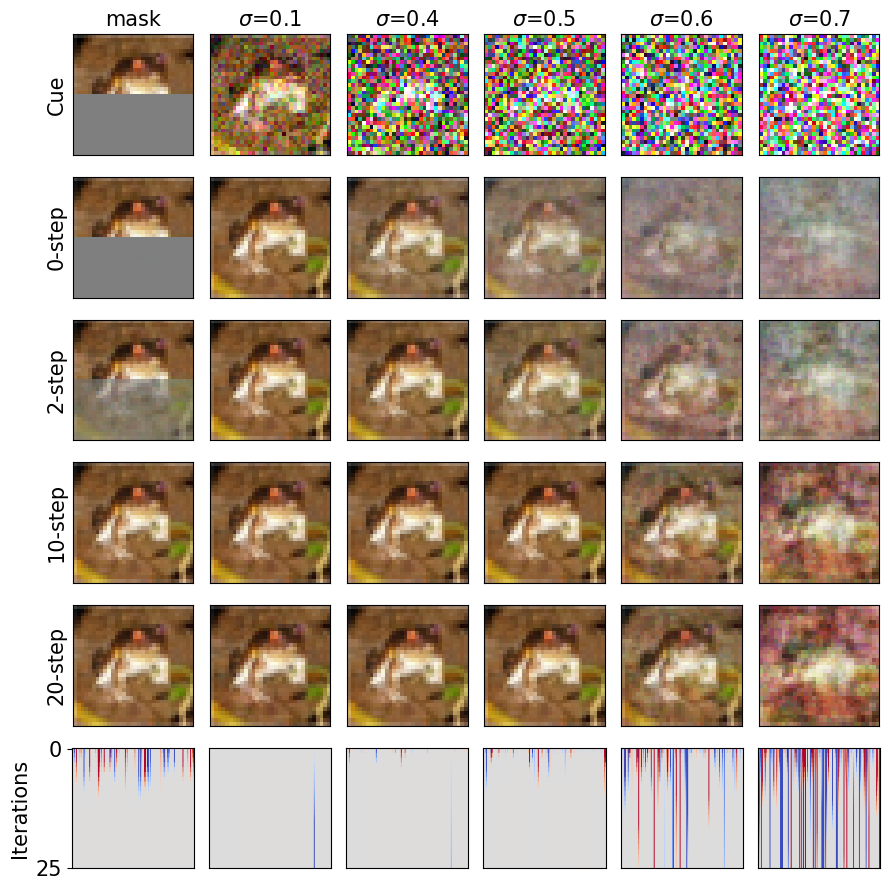

In [6]:
# choose data sample (0 ~ num_pattern-1)
sample_id = 0

emb_size = 128
total_step = 20000
num_pattern = 100
random_idx = 0
ckpt_path = f'./outputs/attractor-{dataset_name}-ckpt/N={emb_size}-npat={num_pattern}-{total_step}step-{random_idx}.pt'

whole_patterns = whole_patterns_raw[:num_pattern].clone()
model = LSHN(['latent'], emb_size, image_size=whole_patterns_raw.shape[-1]).cuda()
model.load_state_dict(torch.load(ckpt_path))
model.eval()
model.set_dt(0.1)

iter_record_ids = [0, 2, 10, 20]
sigma_list = [0.1, 0.4, 0.5, 0.6, 0.7]
with torch.no_grad():
    batch = whole_patterns[sample_id:sample_id+1].clone()

    mask = generate_mask(batch)

    noisy_batch_list = [batch * mask]
    for sigma in sigma_list:
        perturb = torch.normal(0, sigma, size=batch.shape, device=batch.device)
        noisy_batch_list.append(torch.clamp(torch.abs((batch + 1) / 2. + perturb), 0, 1) * 2. - 1)
    noisy_batch = torch.cat(noisy_batch_list, 0)
    batch = torch.cat([batch] * noisy_batch.shape[0], 0)

    target_attractors = model.image_to_attractor(batch)
    noisy_attractors  = model.image_to_attractor(noisy_batch)

    recon_attractors = noisy_attractors.clone()
    recon_image_noisy_list = []
    recon_attractor_list = []
    for i in range(1001):
        if i in iter_record_ids:
            recon_image_noisy_list.append(model.attractor_to_image(recon_attractors).clamp(-1, 1).cpu())
        recon_attractor_list.append(recon_attractors.detach().cpu()[None])
        recon_attractors = model.attractor_iteration(recon_attractors, ento_input=noisy_attractors)
    recon_attractors = torch.sign(recon_attractors)

    recon_image_masked_target = model.attractor_to_image(noisy_attractors).clamp(-1, 1)
    recon_image_target = model.attractor_to_image(target_attractors).clamp(-1, 1)
    recon_image_noisy = model.attractor_to_image(recon_attractors).clamp(-1, 1)

    recon_img_acc_thre50 = Fraction_correctly_retrieved(recon_image_noisy, batch, threshold=50).cpu().numpy(),

    recon_img_ssim = calculate_ssim(pattern2img(recon_image_noisy), pattern2img(batch))

print(recon_img_acc_thre50[0].mean())

plt.figure(figsize=(9, 9))

plot_id = 0

cols_list = ['mask'] + [f'$\sigma$={sigma}' for sigma in sigma_list]
rows = len(iter_record_ids) + 2
for i in range(len(cols_list)):
    plot_id += 1
    plt.subplot(rows, len(cols_list), plot_id)
    plt.title(f'{cols_list[i]}', fontsize=15)
    plt.imshow(pattern2img(noisy_batch[i]))
    if i == 0:
        plt.ylabel('Cue', fontsize=15)
    plt.xticks([])
    plt.yticks([])
for iter_id in range(rows-2):
    for i in range(len(cols_list)):
        plot_id += 1
        plt.subplot(rows, len(cols_list), plot_id)
        plt.imshow(pattern2img(recon_image_noisy_list[iter_id][i]))
        if i == 0:
            plt.ylabel(f'{iter_record_ids[iter_id]}-step', fontsize=15)
        plt.xticks([])
        plt.yticks([])

attractor_trajectory = torch.cat(recon_attractor_list[:25], 0)
attractor_trajectory = attractor_trajectory[:,None].repeat(1, 5, 1, 1).flatten(0, 1)

attractor_trajectory = attractor_trajectory - target_attractors[0,None,None].cpu()

for i in range(len(cols_list)):
    plot_id += 1
    plt.subplot(rows, len(cols_list), plot_id)
    plt.imshow(attractor_trajectory[:,i], cmap='coolwarm', vmin=-1, vmax=1)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel(f'Iterations', fontsize=15)
        plt.yticks([0,len(attractor_trajectory)], ["0", "25"], fontsize=15)
plt.tight_layout()
os.makedirs('outputs/results', exist_ok=True)
plt.savefig(f"outputs/results/{dataset_name}-sample-noise-level-recall-{sample_id}.png", dpi=300)
